# Vortex Plots

Integrative analysis across peak sets and datasets. This one is for binding at naive and primed specific peaks to show a dual naive-primed transient state. See `20200711_naive_vs_primed`.

**Inputs:**
1. List of peak sets
2. Config of samples, bigwig path and class of sample (each class will have same plot styling). If sample belongs to ATAC dataset, old cluster ID else NA.
3. For each cluster, colour, description, new cluster number (set to same as original if it should not be changed)

In [3]:
library(ggplot2)
library(patchwork)
library(reshape2)
library(rtracklayer)
library(scales)
library(viridis)
library(matrixStats)
# library(ggrastr)
library(raster)

Loading required package: sp


Attaching package: ‘sp’


The following object is masked from ‘package:IRanges’:

    %over%



Attaching package: ‘raster’


The following object is masked from ‘package:rtracklayer’:

    values


The following objects are masked from ‘package:GenomicRanges’:

    distance, shift, trim, values, values<-


The following objects are masked from ‘package:IRanges’:

    distance, shift, trim, values, values<-


The following objects are masked from ‘package:S4Vectors’:

    metadata, metadata<-, values, values<-


The following object is masked from ‘package:patchwork’:

    area




## Loading Inputs

### Configs

In [52]:
vortex_config = read.table("./vortex_tracks_config_ESC.tsv", sep='\t', header=T, stringsAsFactors = T)
vortex_config$path = as.character(vortex_config$path)
vortex_config$title = as.character(vortex_config$title)

# manual adjustments
vortex_config[2:6, "title"] = sub(" ", "\n", vortex_config[2:6, "title"])

vortex_config

title,old_cluster,type,group,width,path
<chr>,<int>,<fct>,<int>,<int>,<chr>
Fibroblast,1,ATAC,1,2000,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx1/signal/rep1/cluster_idx1.fc.signal.bigwig
Pre-iPSC (D14),6,ATAC,2,2000,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx6/signal/rep1/cluster_idx6.fc.signal.bigwig
iPSC,8,ATAC,2,2000,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx8/signal/rep1/cluster_idx8.fc.signal.bigwig
Naive hESC,NA,ATAC2,3,2000,/oak/stanford/groups/akundaje/surag/GEO/GSE101074/atac/croo/naive.hESC.atac/signal/pooled-rep/basename_prefix.pooled.fc.signal.bigwig
Primed hESC,NA,ATAC2,3,2000,/oak/stanford/groups/akundaje/surag/GEO/GSE101074/atac/croo/primed.hESC.atac/signal/pooled-rep/basename_prefix.pooled.fc.signal.bigwig
TFAP2C Naive,NA,ChIP2,3,2000,/oak/stanford/groups/akundaje/surag/GEO/GSE101074/chip/croo/naive.tfap2c/signal/pooled-rep/rep.pooled_x_ctl.pooled.fc.signal.bigwig


In [6]:
# manually add if required
# vortex_config[15,] = c("iPSC", 18, "ATAC", 4, 2000, 
#                        "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20200518_n76052/croo/cluster_idx18/signal/rep1/cluster_idx18.fc.signal.bigwig")

# vortex_config$old_cluster = as.integer(vortex_config$old_cluster)
# vortex_config$width = as.integer(vortex_config$width)

In [9]:
peak_set_config = read.table("./vortex_peak_set_config_ESC.tsv", stringsAsFactors = F, comment.char = '', sep='\t', header=T)
peak_set_config$title = gsub("\\.", " ", peak_set_config$title)

peak_set_config[1, "title"] = "TFAP2C-dependent\nNaive Specific"

peak_set_config

title,group,path
<chr>,<int>,<chr>
TFAP2C-dependent Naive Specific,1,/users/surag/kundajelab/scATAC-reprog/resources/GSE101074/TFAP2C.dependent.reg.elements.hg38.bed
Non TFAP2C Naive Specific,1,/users/surag/kundajelab/scATAC-reprog/resources/GSE101074/naive.specific.non.TFAP2C.atac.hg38.bed
Primed Specific,2,/users/surag/kundajelab/scATAC-reprog/resources/GSE101074/primed.specific.atac.hg38.bed


In [10]:
cluster_config = read.table("../configs/cluster.tsv", comment.char = '', header=T, sep='\t', stringsAsFactors=F)

rownames(cluster_config) = cluster_config$cluster
cluster_config

,cluster,colour,description,new_cluster
,<int>,<chr>,<chr>,<int>
1,1,#B03743,Fibroblast,1
2,2,#E85F6D,Fibroblast-like,3
3,3,#7C2730,Fibroblast-like,2
4,4,#F0A118,Intermediate,12
5,5,#78A824,Pre-iPSC,13
6,6,#A6D854,Pre-iPSC,14
7,7,#F01D35,Fibroblast-like,5
8,8,#13C4A3,iPSC,15
9,9,#406614,Partially-reprogrammed,10


### Peak Sets

In [11]:
peak_sets = list()
SUBSAMPLE = 1

for (i in seq(nrow(peak_set_config))) {
    peak_sets[[i]] = import(peak_set_config[i, "path"])
    peak_sets[[i]] = peak_sets[[i]][seq(1,length(peak_sets[[i]]),SUBSAMPLE)]
}

In [12]:
# manually load peaks
# peak_sets = list()
# peak_sets[[1]] = import("/users/surag/kundajelab/scATAC-reprog/resources/GSE101074/TFAP2C.dependent.reg.elements.hg38.bed")
# peak_sets[[1]] = peak_sets[[1]][seq(1,length(peak_sets[[1]]),5)]

# peak_sets[[2]] = import("/users/surag/kundajelab/scATAC-reprog/resources/GSE101074/naive.specific.atac.hg38.bed")
# peak_sets[[2]] = peak_sets[[2]][seq(1,length(peak_sets[[2]]),5)]

# peak_sets[[3]] = import("/users/surag/kundajelab/scATAC-reprog/resources/GSE101074/primed.specific.atac.hg38.bed")
# peak_sets[[3]] = peak_sets[[3]][seq(1,length(peak_sets[[3]]),5)]

In [13]:
peak_set_lens = list()

for (i in seq(length(peak_sets))) {
    peak_set_lens[[i]] = length(peak_sets[[i]])
}

peak_set_lens

sum(unlist(peak_set_lens))

[[1]]
[1] 1560

[[2]]
[1] 3050

[[3]]
[1] 2562

[1] 7172

### Fetch Data from BigWigs

In [14]:
get_matrix_from_bigwig <- function(bigwig_path, peak_set) {
    # ensure peak set has fixed width
    stopifnot(length(unique(width(peak_set)))==1)
    
    as.matrix(import(bigwig_path, 
      which=peak_set, as="NumericList"))
}

In [15]:
matrices = list()

In [16]:
for (i in seq(length(peak_sets))) {
    matrices[[i]] = list()
    
    for (j in seq(nrow(vortex_config))) {
        matrices[[i]][[j]] = get_matrix_from_bigwig(vortex_config[j, "path"], 
                                                    resize(peak_sets[[i]], width=vortex_config[j, "width"], fix='center'))
    }
}

## Compute Orders for Each Peak Set and Reorder

In [17]:
# samples which will be used to decide peak order (based on mean signal across all)
ROW_ORDER_TYPE = "ATAC"

In [18]:
peak_set_orders = list()

In [19]:
for (i in seq(length(peak_sets))) {
    tmp_matrix = do.call(cbind, matrices[[i]][vortex_config$type %in% ROW_ORDER_TYPE])
    peak_set_orders[[i]] = order(rowSums(tmp_matrix))
}

In [20]:
rm(tmp_matrix)

In [21]:
peak_set_orders[[1]][1:10]

[1]  718  190 1495 1494  715  944   33  328  690  864

In [22]:
for (i in seq(length(peak_sets))) {
    for (j in seq(nrow(vortex_config))) {
        matrices[[i]][[j]] = matrices[[i]][[j]][peak_set_orders[[i]], ]
    }
}

## Smooth Samples

In [23]:
y_lims = list()

In [24]:
# find limits for clipping
for (k in seq(length(unique(vortex_config$type)))) {
    type = unique(vortex_config$type)[k]
    
    tmp_matrices = list()
    
    # collapse across time points
    for (i in seq(length(peak_sets))) {
        tmp_matrices[[i]] = do.call(cbind, matrices[[i]][vortex_config$type %in% type])
    }
    
    # collapse across peak sets
    tmp_matrices = do.call(rbind, tmp_matrices)    
    
    y_lims[[type]] = as.numeric(quantile(tmp_matrices, 0.98))
    
}

In [25]:
rm(tmp_matrices)

In [26]:
y_lims

[[1]]
[1] 10.22488

[[2]]
[1] 7.39639

[[3]]
[1] 11.95814

In [27]:
# clip matrices to y_lim
clipped_matrices = list()

for (i in seq(length(peak_sets))) {
    clipped_matrices[[i]] = list()
    
    for (j in seq(nrow(vortex_config))) {
        clipped_matrices[[i]][[j]] = matrices[[i]][[j]]
        clipped_matrices[[i]][[j]][clipped_matrices[[i]][[j]] > y_lims[[vortex_config[j, "type"]]]] = y_lims[[vortex_config[j, "type"]]]
    }
}

In [28]:
create_sum_matrix <- function(n, r) {
  suppressWarnings(matrix(c(rep(1, r), rep(0, n)), n, n/r))
}

In [29]:
# mean downsample matrices along X dimension 
# ENSURE DIM_AFTER_SAMPLE is a divisor of all widths
DIM_AFTER_SAMPLE = 200

smoothed_matrices = list()
for (i in seq(length(peak_sets))) {
    smoothed_matrices[[i]] = list()
    
    for (j in seq(nrow(vortex_config))) {
            stopifnot(ncol(clipped_matrices[[i]][[j]])%%DIM_AFTER_SAMPLE==0)

            scale_factor = ncol(clipped_matrices[[i]][[j]])/DIM_AFTER_SAMPLE
            smoothed_matrices[[i]][[j]] = (1/scale_factor)*(clipped_matrices[[i]][[j]]%*%create_sum_matrix(ncol(clipped_matrices[[i]][[j]]), scale_factor))
    }
}

In [30]:
# mean downsample along samples (y-axis)

Y_SUBSAMPLE_FACTOR = 20
for (i in seq(length(peak_sets))) {
    for (j in seq(nrow(vortex_config))) {
            smoothed_matrices[[i]][[j]] = t((1/Y_SUBSAMPLE_FACTOR)*(t(smoothed_matrices[[i]][[j]])%*%create_sum_matrix(nrow(smoothed_matrices[[i]][[j]]), 
                                                                                                                     Y_SUBSAMPLE_FACTOR)))
    }
}

In [31]:
dim(smoothed_matrices[[1]][[1]])

[1]  78 200

In [32]:
# additional smoothing
# for (i in seq(length(peak_sets))) {
#     for (j in seq(nrow(vortex_config))) {
#         smoothed_matrices[[i]][[j]] =  as.matrix(focal(raster(smoothed_matrices[[i]][[j]]), matrix(1, 3, 3), mean, pad = T, padValue = 0))
#     }
# }

## Decide Limits and Colour Schemes

In [33]:
COLORSCALES = list(scale_fill_viridis_c(option="C", oob=squish), 
               scale_fill_viridis_c(option="D", oob=squish), 
               scale_fill_distiller(palette="Greens", oob=squish, direction=1))

In [34]:
# decide limits for each type
for (k in seq(length(unique(vortex_config$type)))) {
    type = unique(vortex_config$type)[k]
    
    tmp_matrices = list()
    
    # collapse across time points
    for (i in seq(length(peak_sets))) {
        tmp_matrices[[i]] = do.call(cbind, smoothed_matrices[[i]][vortex_config$type %in% type])
    }
    
    # collapse across peak sets
    tmp_matrices = do.call(rbind, tmp_matrices)
    
    low = quantile(tmp_matrices, 0.01)
    high = quantile(tmp_matrices, 0.999)
    
    COLORSCALES[[k]]$limits = c(low, high)
    
}

In [35]:
rm(tmp_matrices)

In [36]:
for (k in seq(length(unique(vortex_config$type)))) {
    print(COLORSCALES[[k]]$limits)
}

       1%     99.9% 
0.1278296 8.9818896 
       1%     99.9% 
0.5063718 6.7664407 
        1%      99.9% 
 0.7079449 10.4716628 


## Plotting

In [53]:
plot_vortex <- function(bwmatrix, color_scale_with_limits,
                       title=NULL, clust_name=NULL, ticks=NULL) {
    # ticks is a number and if not null, will make ticks at
    # left and right end with +ticks kb and -ticks kb
    
    melted = melt(bwmatrix)
    
    plot <- ggplot(melted, aes(x=Var2, y= Var1, fill=value)) +
#     geom_tile_rast() + # kinda slow, geom_raster is faster and smaller files
#     geom_tile() +
    geom_raster() +
    color_scale_with_limits + 
    scale_y_continuous(expand = c(0, 0)) + # this removes whitespace between plot and border
    theme_void() 
    
    if (!is.null(title)) {
        plot = plot + ggtitle(title) +
        theme(plot.title = element_text(hjust = 0.5))
    }
    
    if (!is.null(clust_name)) {
        plot = plot + ylab(sprintf("%s\n", clust_name)) + 
             theme(axis.title.y = element_text(angle=90, vjust=0.5))
    }
    
    if (!is.null(ticks)) {
        plot = plot + scale_x_continuous(breaks = c(1, ncol(bwmatrix)/2, ncol(bwmatrix)), 
                                         labels = c(sprintf("-%dkb", ticks), "",
                                                    sprintf("+%dkb", ticks)),
                                         expand = c(0,0)) # this removes whitespace between plot and border
        plot = plot + theme(axis.ticks.length=unit(.25, "cm"),
                           axis.text.x = element_text(size=10))
    }
                                         
    else {
        plot = plot + 
               scale_x_continuous(expand=c(0,0)) + # this removes whitespace between plot and border
               theme(axis.ticks.x=element_blank(),
                    axis.text.x = element_blank(),) 
    }
    
    plot = plot + theme(legend.position = "none",             
            axis.title.x = element_blank(),
#             axis.text.y=element_blank(),
            axis.line=element_blank(),
            axis.ticks.y=element_blank(),
            plot.margin = unit(c(0,2,0,2), "pt"), # right tick label was clipping
          panel.border = element_rect(colour = "black", fill=NA, size=0.5))
    
    plot
}

In [54]:
# bwm_clipped = bwm
# bwm_clipped[bwm_clipped>quantile(bwm, 0.99)] = quantile(bwm, 0.99)
# bwm_clipped_ordered = bwm_clipped[order(rowMeans(bwm)), ]
# bwm_clipped_smoothed = as.matrix(focal(raster(bwm_clipped_ordered), matrix(1, 11, 3), mean, pad = T, padValue = 0))
# quantile(bwm_clipped_smoothed, c(0.95, 0.98, .99,.999, .9999, 1))
# vortex_plot <- plot_vortex(bwm_clipped_smoothed[1:100,], scale_fill_distiller(palette = "Reds"))

In [55]:
all_plots = list()
row_widths = list()

In [56]:
X_SPACER_WIDTH = -0.1
X_NON_SPACER_WIDTH = -0.15

for (i in seq(length(peak_sets))) {
    tot_plots = 1
    all_plots[[i]] = list()
    
    for (j in seq(nrow(vortex_config))) {
        if (j>1) {
            all_plots[[i]][[tot_plots]] = plot_spacer() # spacing between every consecutive plot
            
            if (vortex_config[j,"group"]!=vortex_config[j-1,"group"]) {
            row_widths[[tot_plots]] = X_SPACER_WIDTH # spacing between groups
            }
            else {
                row_widths[[tot_plots]] = X_NON_SPACER_WIDTH # spacing within groups
            }
            
            tot_plots = tot_plots + 1
        }
        
        title = NULL
        ticks = NULL
        clust_name = NULL
        if (i==1) {
            title = vortex_config[j, "title"]
        }
        
        if (j==1) {
            clust_name = peak_set_config$title[i]
        }
        # TODO: ticks mess margins
#         else if (i==length(peak_sets)) {
#             ticks = vortex_config[j, "width"]/2000
#         }
        
        all_plots[[i]][[tot_plots]] = plot_vortex(smoothed_matrices[[i]][[j]][seq(1, nrow(smoothed_matrices[[i]][[j]]), 1),],
                                         COLORSCALES[[as.numeric(vortex_config[j, "type"])]],
                                                 title=title,
                                                 clust_name=clust_name,
                                                 ticks=ticks)
        row_widths[[tot_plots]] = 1
        tot_plots = tot_plots + 1
    }
}

In [57]:
Y_SPACER_WIDTH = -0.1
Y_NON_SPACER_WIDTH = -0.11

rowwise_plots = list()
col_heights = list()
tot_plots = 1

for (i in seq(length(peak_sets))) {
    if (i>1) {
        rowwise_plots[[tot_plots]] = plot_spacer() # spacing between groups
        
        if (peak_set_config[i,"group"]!=peak_set_config[i-1,"group"]) {
            col_heights[[tot_plots]] = Y_SPACER_WIDTH*mean(unlist(peak_set_lens)) # spacing between groups
        }
        else {
            col_heights[[tot_plots]] = Y_NON_SPACER_WIDTH*mean(unlist(peak_set_lens)) # spacing within groups
        }
        
        tot_plots = tot_plots + 1
    }
    
    rowwise_plots[[tot_plots]] =  wrap_plots(all_plots[[i]], nrow = 1, widths = row_widths)
    col_heights[[tot_plots]] = peak_set_lens[[i]]
    
    tot_plots = tot_plots + 1
}

In [58]:
length(row_widths)
length(col_heights)

[1] 11

[1] 5

In [59]:
length(all_plots[[1]])
length(rowwise_plots)
# length(all_plots[[2]])

[1] 11

[1] 5

### Assemble Integration

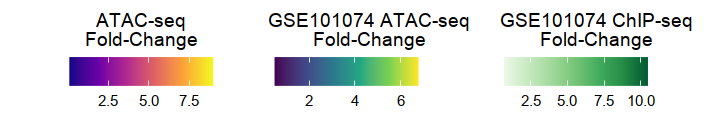

In [60]:
# legends
legend_titles = c("ATAC-seq\nFold-Change",
                 "GSE101074 ATAC-seq\nFold-Change",
                 "GSE101074 ChIP-seq\nFold-Change")
legends = list()

for (k in seq(length(unique(vortex_config$type)))) {
    legends[[k]] = cowplot::get_legend(ggplot(data = data.frame(Var1=c(1), Var2=c(1), value=c(1)), 
                   aes(x = Var2, y = Var1, fill = value)) +
            geom_raster() +  
            COLORSCALES[[k]] +
            labs(fill=legend_titles[k]) +
            theme(legend.position = "bottom") +
            guides(fill = guide_colourbar(title.position="top",
                    title.hjust=0.5)))
}

options(repr.plot.width = 6, repr.plot.height = 1)

legend_plot = wrap_plots(plot_spacer(), wrap_plots(legends, nrow=1), widths=c(0,1))
legend_plot

In [61]:
# options(repr.plot.width = 3, repr.plot.height = 9)

# wrap_plots(wrap_plots(all_plots[[1]][[1]],all_plots[[1]][[5]],nrow=1),
#            plot_spacer(),
#            wrap_plots(all_plots[[2]][[1]],all_plots[[2]][[5]],nrow=1),
#            plot_spacer(),
#            wrap_plots(all_plots[[3]][[1]],all_plots[[3]][[5]],nrow=1)
#            , ncol=1, heights=c(1,-0.15,1,-0.15,1)) 

In [62]:
top_annotate_plot = ggplot() + 
                theme_void() +
                geom_line() +
                coord_cartesian(xlim = c(0.5,9.5), # this let's use 0-10 on x axis to place items
                               ylim=c(0,10)) + # this let's use 0-10 on y axis to place items
#                 annotate("segment", x = 0, xend = 1.1, y = 2, yend = 2, size=1, colour = "black") +
#                 annotate("text", x = .55, y = 5, size=5, label = "Fibroblasts") +

                annotate("segment", x = 5.2, xend = 10, y = 2, yend = 2, size=1, colour = "black")  +
                annotate("text", x = 7.6, y = 5, size=5, label = "GSE101074") 
#                 annotate("text", x = 2, y = 25, label = "Some text")

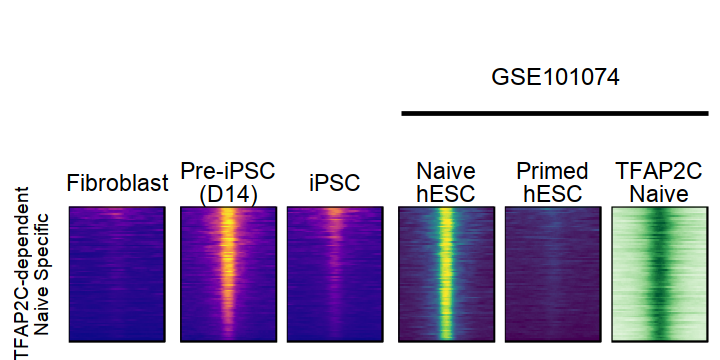

In [63]:
options(repr.plot.width = 6, repr.plot.height = 3)

wrap_plots(top_annotate_plot,
           rowwise_plots[[1]],
           heights=c(1,1))

In [64]:
# left_annotate_plot = ggplot() + 
#                 theme_void() +
#                 geom_line() +
#                 coord_cartesian(xlim = c(0.5,9.5), # this let's use 0-10 on x axis to place items
#                                ylim=c(0.5,9.5)) + # this let's use 0-10 on y axis to place items
#                 annotate("segment", x = 8, xend = 8, y = 0, yend = 3.4, size=1, colour = "black") +
#                 annotate("text", x = 5, y =1.7, size=5, angle=90, label = "Close Open") +

#                 annotate("segment", x = 8, xend = 8, y = 3.5, yend = 6.7, size=1, colour = "black") +
#                 annotate("text", x = 5, y = 5.1, size=5, angle=90, label = "Transient") +

#                 annotate("segment", x = 8, xend = 8, y = 6.8, yend = 10, size=1, colour = "black")  +
#                 annotate("text", x = 5, y = 8.4, size=5, angle=90, label = "Open Close") 
# #                 annotate("text", x = 2, y = 25, label = "Some text")

In [65]:
# options(repr.plot.width = 2, repr.plot.height = 10.5)


# first_col = list()
# for (j in seq(length(rowwise_plots))) {
#    if ("spacer" %in% class(rowwise_plots[[j]])) {
#       first_col[[j]] = plot_spacer()
#    }
#    else {
#        first_col[[j]] = rowwise_plots[[j]][[1]]    
#     }
# }
# first_col_plot = wrap_plots(first_col, 
#                            heights=col_heights)

# wrap_plots(left_annotate_plot,
#            first_col_plot,
#            widths=c(1,1))

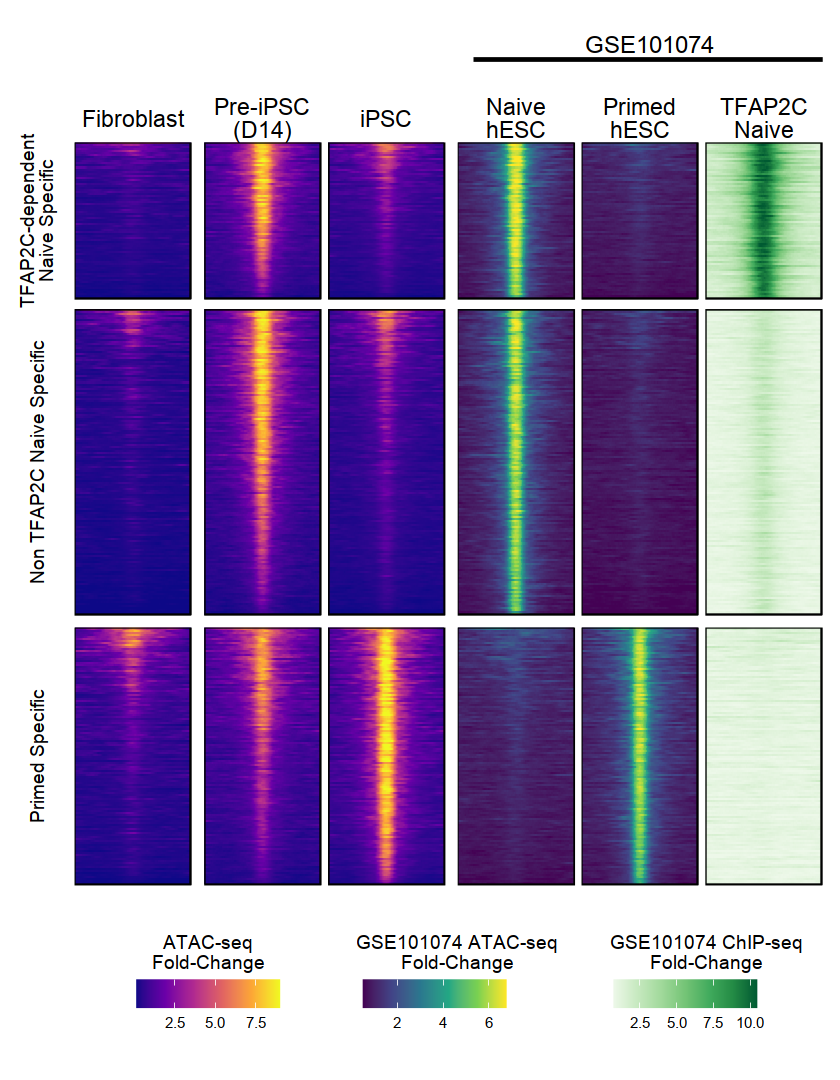

In [66]:
options(repr.plot.width = 7, repr.plot.height = 9)
vortex_grid = wrap_plots(
    rowwise_plots,
    ncol=1,
    heights = col_heights)

# vortex_grid_w_left_anno = wrap_plots(left_annotate_plot, 
#                                      vortex_grid,
#                                     widths=c(1,12))

top_annotate_plot_w_space = wrap_plots(plot_spacer(),
                                       top_annotate_plot,
                                      widths=c(0.1,5.9)) # adjust to account for cluster name text

complete_plot = wrap_plots(top_annotate_plot_w_space,
                                        vortex_grid,
                                        legend_plot,
                                        heights=c(0.5,7,1.5))
complete_plot

In [67]:
ggsave("./subfigs/20210906_GSE101074_vortex.pdf", complete_plot, width=7,height=9)

In [278]:
saveRDS(complete_plot, file=sprintf("./subfigs/%s_vortex.rds",
                                format(Sys.Date(), "%Y%m%d")))

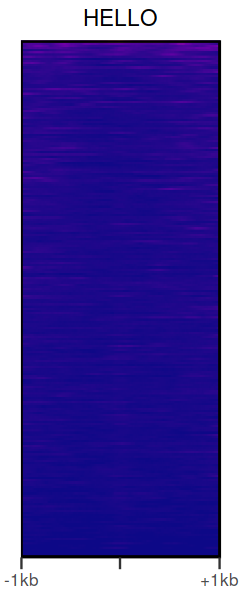

In [245]:
options(repr.plot.width = 2, repr.plot.height = 5)
plot_vortex(smoothed_matrices[[1]][[1]], 
            COLORSCALES[[as.numeric(vortex_config[1, "type"])]], 
            title="HELLO", ticks=1)